# Artificial Neural Network (male)

In [13]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras.utils import np_utils
from tensorflow.keras import optimizers
%matplotlib inline

In [2]:
alzheimer = pd.read_csv('adni_ixi_rois_data_raw.csv', delimiter=',',header=0)
print(alzheimer.shape)
print(alzheimer.head())
print(alzheimer.info())
print(alzheimer.describe())

(2436, 453)
   lh_bankssts_area  lh_caudalanteriorcingulate_area  \
0               879                              528   
1               845                              525   
2               884                              605   
3               846                              612   
4               834                              324   

   lh_caudalmiddlefrontal_area  lh_cuneus_area  lh_entorhinal_area  \
0                         1968            1072                 253   
1                         1892            1064                 285   
2                         2093            1449                 524   
3                         2035            1485                 521   
4                         2140            1518                 309   

   lh_fusiform_area  lh_inferiorparietal_area  lh_inferiortemporal_area  \
0              2307                      3573                      2445   
1              2232                      3670                      2383   
2    

In [3]:
#Check for missign values
total=alzheimer.isnull().sum().sort_values(ascending=False)
percent = round(alzheimer.isnull().sum().sort_values(ascending = False)/len(alzheimer)*100, 2)
pd.concat([total, percent], axis = 1,keys= ['Total', 'Percent'])


,Total,Percent
Age,0,0.0
lh_superiortemporal_volume,0,0.0
lh_caudalmiddlefrontal_volume,0,0.0
lh_cuneus_volume,0,0.0
lh_entorhinal_volume,0,0.0
...,...,...
rh_superiortemporal_thickness,0,0.0
rh_supramarginal_thickness,0,0.0
rh_frontalpole_thickness,0,0.0
rh_temporalpole_thickness,0,0.0


In [4]:
#Remove attributes with 0s and systematically inconsistent
alzheimers=alzheimer.drop(['eTIV', '5th-Ventricle', 'Left-WM-hypointensities','Right-WM-hypointensities','non-WM-hypointensities','Left-non-WM-hypointensities','Right-non-WM-hypointensities','Left-vessel','Right-vessel','lhSurfaceHoles','rhSurfaceHoles','SurfaceHoles'], axis = 1)
print(alzheimers.shape)

noisefiltered=alzheimers[alzheimers['total CNR']>0.9]
print(noisefiltered.head())
print(noisefiltered.shape)

sortedfiltered=noisefiltered.sort_values('SID', ascending=False)
print(sortedfiltered.head())
print(sortedfiltered.shape)

(2436, 441)
   lh_bankssts_area  lh_caudalanteriorcingulate_area  \
0               879                              528   
1               845                              525   
2               884                              605   
3               846                              612   
4               834                              324   

   lh_caudalmiddlefrontal_area  lh_cuneus_area  lh_entorhinal_area  \
0                         1968            1072                 253   
1                         1892            1064                 285   
2                         2093            1449                 524   
3                         2035            1485                 521   
4                         2140            1518                 309   

   lh_fusiform_area  lh_inferiorparietal_area  lh_inferiortemporal_area  \
0              2307                      3573                      2445   
1              2232                      3670                      2383   
2    

In [5]:
#Filter out duplicate values, keeping the first value
duplicates=sortedfiltered.drop_duplicates(subset='SID',keep = 'first') 
print(duplicates.head())
print(duplicates.info())


      lh_bankssts_area  lh_caudalanteriorcingulate_area  \
2237              1382                              399   
2236              1031                              604   
2235              1115                              604   
2234               984                              601   
2233              1039                              514   

      lh_caudalmiddlefrontal_area  lh_cuneus_area  lh_entorhinal_area  \
2237                         2328            1713                 536   
2236                         2334            1628                 382   
2235                         2674            1805                 406   
2234                         2513            1494                 575   
2233                         2305            1964                 463   

      lh_fusiform_area  lh_inferiorparietal_area  lh_inferiortemporal_area  \
2237              4280                      5523                      4045   
2236              2709                      5016  

In [6]:
#Encode labels and drop unecessary columns
label_quality = LabelEncoder()
duplicates['Research Group'] = label_quality.fit_transform(duplicates['Research Group'])
train=duplicates.copy()
train.drop(['Age','SID', 'total CNR','Study'], axis=1, inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1215 entries, 2237 to 767
Columns: 437 entries, lh_bankssts_area to Research Group
dtypes: float64(284), int64(152), object(1)
memory usage: 4.1+ MB


/home/fs838120/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
#filter out by male and female
male=train[train['Gender']=='M']
male.shape
male.head()
male.info()

female=train[train['Gender']=='F']
female.shape
female.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 575 entries, 2237 to 767
Columns: 437 entries, lh_bankssts_area to Research Group
dtypes: float64(284), int64(152), object(1)
memory usage: 1.9+ MB


,lh_bankssts_area,lh_caudalanteriorcingulate_area,lh_caudalmiddlefrontal_area,lh_cuneus_area,lh_entorhinal_area,lh_fusiform_area,lh_inferiorparietal_area,lh_inferiortemporal_area,lh_isthmuscingulate_area,lh_lateraloccipital_area,...,right_parasubiculum,right_molecular_layer_HP,right_GC-ML-DG,right_CA3,right_CA4,right_fimbria,right_HATA,right_Whole_hippocampus,Gender,Research Group
2220,862,530,2037,1289,535,2929,3952,3047,819,4568,...,46.461919,434.595503,231.404698,162.388210,197.017748,70.285099,56.145862,2857.525319,F,1
2219,816,547,2181,1408,513,2911,3146,2675,838,4583,...,50.964043,539.436587,284.107845,190.369238,238.195497,79.764626,66.806796,3344.279277,F,1
2216,899,607,1827,1365,378,3123,4316,3046,787,5403,...,32.580984,532.200366,292.456888,210.220181,250.866354,33.304657,62.685547,3150.591207,F,1
2210,880,779,1821,1507,375,3069,4479,3630,925,4488,...,48.457593,581.810977,327.605965,251.333255,279.380102,59.665453,54.737106,3514.416839,F,1
2208,859,571,1602,1272,264,2551,3907,2887,711,4722,...,39.616299,461.266237,260.890460,199.302961,220.133679,43.914119,47.364900,2811.495889,F,1


In [8]:
#Drop category labels and gender labels
y_male = male["Research Group"]
X_male = male.drop(["Research Group",'Gender'], axis = 1)

In [9]:
#Normalise the data between 0 and 1
sc=StandardScaler()
X_scaled_male = sc.fit_transform(X_male)

In [10]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_male, y_male,test_size = 0.3, random_state=42)   #scale the test data as well
#Train Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [71]:
#Build sequential model
model = Sequential()
model.add(Dense(435, input_dim=435, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.summary()


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 435)               189660    
_________________________________________________________________
dropout_51 (Dropout)         (None, 435)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 300)               130800    
_________________________________________________________________
dropout_52 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 150)               45150     
_________________________________________________________________
dropout_53 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 1)               

In [72]:
model.get_config()
model.get_weights()


[array([[ 0.02146677,  0.08085255, -0.00078218, ..., -0.06045693,
          0.03357972, -0.02789754],
        [-0.00544764,  0.02384239, -0.04478688, ...,  0.01018136,
         -0.04876981,  0.01319062],
        [-0.027249  , -0.02464639,  0.06692448, ..., -0.0445007 ,
         -0.04661878, -0.02356228],
        ...,
        [ 0.02309906,  0.05306065, -0.00461952, ...,  0.05183977,
         -0.06172988,  0.04068482],
        [-0.03251296, -0.00999849,  0.00397829, ...,  0.04557477,
          0.03804328,  0.06751534],
        [ 0.06434299,  0.0793886 , -0.06549358, ...,  0.02351971,
         -0.03036787,  0.04750191]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [73]:
#Compile and fit the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
history=model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),verbose=1)

Train on 402 samples, validate on 81 samples
Epoch 1/50
402/402 [==============================] - 1s 3ms/sample - loss: 0.7855 - accuracy: 0.4677 - val_loss: 0.6782 - val_accuracy: 0.5679
Epoch 2/50
402/402 [==============================] - 0s 284us/sample - loss: 0.6689 - accuracy: 0.5995 - val_loss: 0.6348 - val_accuracy: 0.6173
Epoch 3/50
402/402 [==============================] - 0s 271us/sample - loss: 0.6504 - accuracy: 0.6294 - val_loss: 0.5997 - val_accuracy: 0.6667
Epoch 4/50
402/402 [==============================] - 0s 285us/sample - loss: 0.6452 - accuracy: 0.6493 - val_loss: 0.5661 - val_accuracy: 0.6914
Epoch 5/50
402/402 [==============================] - 0s 280us/sample - loss: 0.5792 - accuracy: 0.7040 - val_loss: 0.5387 - val_accuracy: 0.7160
Epoch 6/50
402/402 [==============================] - 0s 260us/sample - loss: 0.6097 - accuracy: 0.6418 - val_loss: 0.5142 - val_accuracy: 0.7654
Epoch 7/50
402/402 [==============================] - 0s 264us/sample - loss: 0.5

# Validation of the model

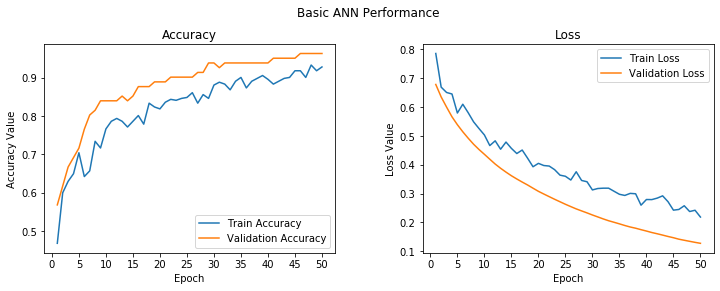

In [74]:
#Print out the statistics from the classifier
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic ANN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
#Plotting accuracy Statistics according to epoch
epoch_list = list(range(1,51))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 51, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 51, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [75]:
y_pred = model.predict(X_test)
print(y_pred)

[[0.01698891]
 [0.79947805]
 [0.99954647]
 [0.7612207 ]
 [0.14207388]
 [0.73260796]
 [0.9972983 ]
 [0.9767528 ]
 [0.9438065 ]
 [0.98410666]
 [0.95128995]
 [0.9897363 ]
 [0.2022935 ]
 [0.94849175]
 [0.5611109 ]
 [0.23089659]
 [0.469814  ]
 [0.9960199 ]
 [0.07136527]
 [0.78388   ]
 [0.00968746]
 [0.46933225]
 [0.02275739]
 [0.9861119 ]
 [0.9178563 ]
 [0.87673044]
 [0.12289356]
 [0.66040695]
 [0.00950183]
 [0.23551852]
 [0.09237231]
 [0.9702959 ]
 [0.91867226]
 [0.95416135]
 [0.92978317]
 [0.8102929 ]
 [0.40412247]
 [0.99556386]
 [0.93229556]
 [0.71356565]
 [0.618815  ]
 [0.01905194]
 [0.07836024]
 [0.02562696]
 [0.6131683 ]
 [0.9878698 ]
 [0.03012318]
 [0.9640319 ]
 [0.09436515]
 [0.997928  ]
 [0.04499338]
 [0.3682657 ]
 [0.9254093 ]
 [0.9912922 ]
 [0.9662968 ]
 [0.8857483 ]
 [0.3627811 ]
 [0.03898173]
 [0.860523  ]
 [0.9780432 ]
 [0.96258634]
 [0.99697256]
 [0.05245712]
 [0.9763851 ]
 [0.9930813 ]
 [0.8971574 ]
 [0.00876671]
 [0.04641272]
 [0.98441964]
 [0.98344135]
 [0.910231  ]
 [0.03

In [76]:
score = model.evaluate(X_test, y_test,verbose=1)
print(score)

173/173 [==============================] - 0s 174us/sample - loss: 0.3197 - accuracy: 0.8728
[0.3197273495741662, 0.87283236]


In [77]:
print(confusion_matrix(y_test, y_pred.round()))
print(classification_report(y_test,y_pred.round()))

[[ 47  12]
 [ 10 104]]
              precision    recall  f1-score   support

           0       0.82      0.80      0.81        59
           1       0.90      0.91      0.90       114

    accuracy                           0.87       173
   macro avg       0.86      0.85      0.86       173
weighted avg       0.87      0.87      0.87       173



0.9272970561998215


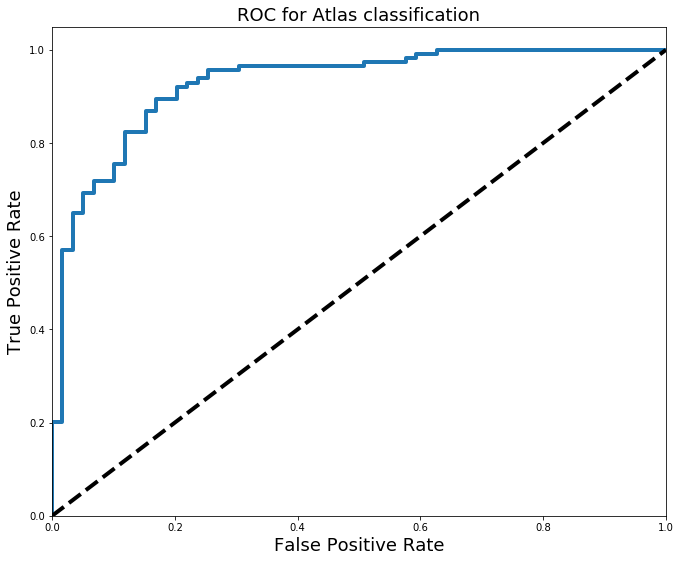

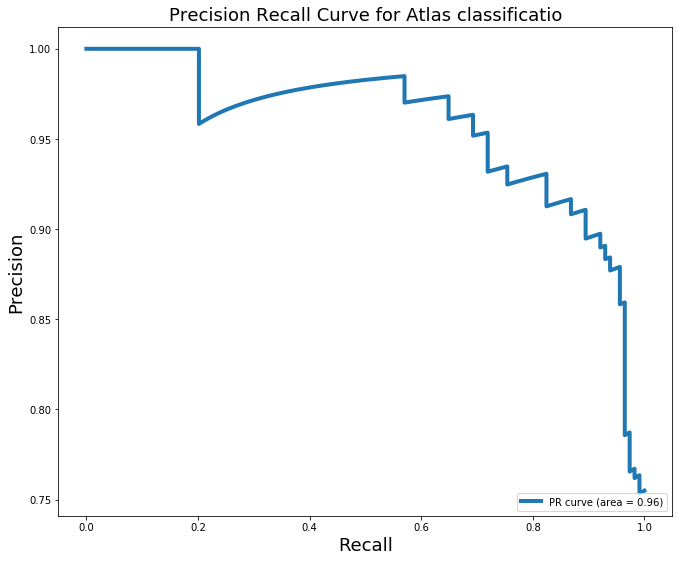

In [78]:
FPR, TPR, _ = roc_curve(y_test, y_pred)
ROC_AUC = auc(FPR, TPR)
print (ROC_AUC)

plt.figure(figsize =[11,9])
plt.plot(FPR, TPR, label= 'ROC curve(area = %0.2f)'%ROC_AUC, linewidth= 4)
plt.plot([0,1],[0,1], 'k--', linewidth = 4)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('ROC for Atlas classification', fontsize= 18)
plt.show()
#Precision recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
PR_AUC = auc(recall, precision)

plt.figure(figsize=[11,9])
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % PR_AUC, linewidth=4)
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision Recall Curve for Atlas classificatio', fontsize=18)
plt.legend(loc="lower right")
plt.show()

# Artificial neural network Cross Validation

In [79]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = Sequential()
    model.add(Dense(435, input_dim=435, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(300, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(150, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
    return model


In [80]:
#Repartition the normalised data
X_train, X_test, y_train, y_test = train_test_split(X_scaled_male, y_male,test_size = 0.3, random_state=42)

In [81]:
#Now with cross validation 10 fold
k = 10
num_val_samples = len(X_train) // k
num_epochs = 50
all_accuracy_history = []
for i in range(k):
    print('processing fold #', i+1)
    # Prepare the validation data: data from partition # k
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [X_train[:i * num_val_samples],
         X_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
        y_train[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=1)
    accuracy_history = history.history['accuracy']
    all_accuracy_history.append(accuracy_history)


processing fold # 1
Train on 362 samples, validate on 40 samples
Epoch 1/50
362/362 [==============================] - 3s 8ms/sample - loss: 0.6263 - accuracy: 0.6851 - val_loss: 0.5445 - val_accuracy: 0.7250
Epoch 2/50
362/362 [==============================] - 2s 5ms/sample - loss: 0.5114 - accuracy: 0.7320 - val_loss: 0.4932 - val_accuracy: 0.7500
Epoch 3/50
362/362 [==============================] - 2s 5ms/sample - loss: 0.4572 - accuracy: 0.7983 - val_loss: 0.4551 - val_accuracy: 0.8000
Epoch 4/50
362/362 [==============================] - 2s 4ms/sample - loss: 0.4094 - accuracy: 0.8287 - val_loss: 0.4212 - val_accuracy: 0.8000
Epoch 5/50
362/362 [==============================] - 2s 4ms/sample - loss: 0.3873 - accuracy: 0.8260 - val_loss: 0.3983 - val_accuracy: 0.8250
Epoch 6/50
362/362 [==============================] - 2s 4ms/sample - loss: 0.3585 - accuracy: 0.8536 - val_loss: 0.3746 - val_accuracy: 0.8500
Epoch 7/50
362/362 [==============================] - 2s 4ms/sample - l

Epoch 7/50
362/362 [==============================] - 2s 4ms/sample - loss: 0.3608 - accuracy: 0.8453 - val_loss: 0.4126 - val_accuracy: 0.8750
Epoch 8/50
362/362 [==============================] - 2s 5ms/sample - loss: 0.3589 - accuracy: 0.8702 - val_loss: 0.4269 - val_accuracy: 0.8750
Epoch 9/50
362/362 [==============================] - 2s 5ms/sample - loss: 0.3342 - accuracy: 0.8619 - val_loss: 0.4273 - val_accuracy: 0.8750
Epoch 10/50
362/362 [==============================] - 2s 5ms/sample - loss: 0.3067 - accuracy: 0.8674 - val_loss: 0.4435 - val_accuracy: 0.8750
Epoch 11/50
362/362 [==============================] - 2s 5ms/sample - loss: 0.3147 - accuracy: 0.8867 - val_loss: 0.4586 - val_accuracy: 0.8750
Epoch 12/50
362/362 [==============================] - 2s 5ms/sample - loss: 0.2932 - accuracy: 0.9033 - val_loss: 0.4726 - val_accuracy: 0.8750
Epoch 13/50
362/362 [==============================] - 2s 4ms/sample - loss: 0.3011 - accuracy: 0.9061 - val_loss: 0.4868 - val_accur

362/362 [==============================] - 2s 4ms/sample - loss: 0.2774 - accuracy: 0.9116 - val_loss: 0.3952 - val_accuracy: 0.8250
Epoch 14/50
362/362 [==============================] - 2s 4ms/sample - loss: 0.2762 - accuracy: 0.9061 - val_loss: 0.4007 - val_accuracy: 0.8250
Epoch 15/50
362/362 [==============================] - 1s 4ms/sample - loss: 0.2634 - accuracy: 0.9061 - val_loss: 0.3970 - val_accuracy: 0.8750
Epoch 16/50
362/362 [==============================] - 2s 4ms/sample - loss: 0.2256 - accuracy: 0.9171 - val_loss: 0.3919 - val_accuracy: 0.8750
Epoch 17/50
362/362 [==============================] - 2s 4ms/sample - loss: 0.2263 - accuracy: 0.9309 - val_loss: 0.4026 - val_accuracy: 0.9000
Epoch 18/50
362/362 [==============================] - 2s 4ms/sample - loss: 0.2437 - accuracy: 0.9392 - val_loss: 0.4073 - val_accuracy: 0.9000
Epoch 19/50
362/362 [==============================] - 2s 4ms/sample - loss: 0.2325 - accuracy: 0.9227 - val_loss: 0.4064 - val_accuracy: 0.90

362/362 [==============================] - 2s 5ms/sample - loss: 0.2208 - accuracy: 0.9282 - val_loss: 0.4566 - val_accuracy: 0.9250
Epoch 20/50
362/362 [==============================] - 2s 5ms/sample - loss: 0.2178 - accuracy: 0.9448 - val_loss: 0.4682 - val_accuracy: 0.9250
Epoch 21/50
362/362 [==============================] - 2s 4ms/sample - loss: 0.1935 - accuracy: 0.9337 - val_loss: 0.4849 - val_accuracy: 0.9250
Epoch 22/50
362/362 [==============================] - 2s 4ms/sample - loss: 0.2288 - accuracy: 0.9309 - val_loss: 0.4901 - val_accuracy: 0.9250
Epoch 23/50
362/362 [==============================] - 2s 5ms/sample - loss: 0.2175 - accuracy: 0.9365 - val_loss: 0.4989 - val_accuracy: 0.9250
Epoch 24/50
362/362 [==============================] - 2s 5ms/sample - loss: 0.1692 - accuracy: 0.9420 - val_loss: 0.5075 - val_accuracy: 0.9250
Epoch 25/50
362/362 [==============================] - 2s 5ms/sample - loss: 0.1622 - accuracy: 0.9309 - val_loss: 0.5184 - val_accuracy: 0.92

362/362 [==============================] - 2s 5ms/sample - loss: 0.1632 - accuracy: 0.9475 - val_loss: 0.4995 - val_accuracy: 0.8750
Epoch 26/50
362/362 [==============================] - 2s 5ms/sample - loss: 0.1584 - accuracy: 0.9613 - val_loss: 0.5177 - val_accuracy: 0.9000
Epoch 27/50
362/362 [==============================] - 2s 4ms/sample - loss: 0.1499 - accuracy: 0.9475 - val_loss: 0.5198 - val_accuracy: 0.9000
Epoch 28/50
362/362 [==============================] - 2s 5ms/sample - loss: 0.1494 - accuracy: 0.9586 - val_loss: 0.5391 - val_accuracy: 0.9000
Epoch 29/50
362/362 [==============================] - 2s 5ms/sample - loss: 0.1379 - accuracy: 0.9475 - val_loss: 0.5548 - val_accuracy: 0.8750
Epoch 30/50
362/362 [==============================] - 2s 5ms/sample - loss: 0.1340 - accuracy: 0.9641 - val_loss: 0.5631 - val_accuracy: 0.9000
Epoch 31/50
362/362 [==============================] - 2s 5ms/sample - loss: 0.1324 - accuracy: 0.9641 - val_loss: 0.5801 - val_accuracy: 0.90

362/362 [==============================] - 2s 5ms/sample - loss: 0.1477 - accuracy: 0.9530 - val_loss: 0.2104 - val_accuracy: 0.9500
Epoch 32/50
362/362 [==============================] - 2s 5ms/sample - loss: 0.1294 - accuracy: 0.9613 - val_loss: 0.2090 - val_accuracy: 0.9500
Epoch 33/50
362/362 [==============================] - 2s 4ms/sample - loss: 0.1123 - accuracy: 0.9696 - val_loss: 0.2138 - val_accuracy: 0.9500
Epoch 34/50
362/362 [==============================] - 2s 5ms/sample - loss: 0.1041 - accuracy: 0.9724 - val_loss: 0.1973 - val_accuracy: 0.9500
Epoch 35/50
362/362 [==============================] - 2s 4ms/sample - loss: 0.1003 - accuracy: 0.9613 - val_loss: 0.1924 - val_accuracy: 0.9500
Epoch 36/50
362/362 [==============================] - 2s 4ms/sample - loss: 0.0954 - accuracy: 0.9751 - val_loss: 0.2000 - val_accuracy: 0.9500
Epoch 37/50
362/362 [==============================] - 2s 4ms/sample - loss: 0.1023 - accuracy: 0.9641 - val_loss: 0.2110 - val_accuracy: 0.95

362/362 [==============================] - 2s 4ms/sample - loss: 0.1105 - accuracy: 0.9751 - val_loss: 0.4767 - val_accuracy: 0.8750
Epoch 38/50
362/362 [==============================] - 1s 4ms/sample - loss: 0.1004 - accuracy: 0.9751 - val_loss: 0.5114 - val_accuracy: 0.8750
Epoch 39/50
362/362 [==============================] - 1s 4ms/sample - loss: 0.0935 - accuracy: 0.9724 - val_loss: 0.5386 - val_accuracy: 0.8750
Epoch 40/50
362/362 [==============================] - 1s 4ms/sample - loss: 0.0785 - accuracy: 0.9890 - val_loss: 0.5435 - val_accuracy: 0.8750
Epoch 41/50
362/362 [==============================] - 2s 4ms/sample - loss: 0.0844 - accuracy: 0.9779 - val_loss: 0.5776 - val_accuracy: 0.8750
Epoch 42/50
362/362 [==============================] - 2s 4ms/sample - loss: 0.1437 - accuracy: 0.9641 - val_loss: 0.5962 - val_accuracy: 0.8750
Epoch 43/50
362/362 [==============================] - 2s 4ms/sample - loss: 0.0772 - accuracy: 0.9834 - val_loss: 0.6204 - val_accuracy: 0.87

362/362 [==============================] - 2s 5ms/sample - loss: 0.0875 - accuracy: 0.9834 - val_loss: 0.5005 - val_accuracy: 0.9250
Epoch 44/50
362/362 [==============================] - 2s 5ms/sample - loss: 0.1249 - accuracy: 0.9751 - val_loss: 0.5299 - val_accuracy: 0.9250
Epoch 45/50
362/362 [==============================] - 2s 5ms/sample - loss: 0.0933 - accuracy: 0.9779 - val_loss: 0.5400 - val_accuracy: 0.9250
Epoch 46/50
362/362 [==============================] - 2s 5ms/sample - loss: 0.0786 - accuracy: 0.9807 - val_loss: 0.5558 - val_accuracy: 0.9250
Epoch 47/50
362/362 [==============================] - 2s 5ms/sample - loss: 0.0734 - accuracy: 0.9751 - val_loss: 0.5613 - val_accuracy: 0.9250
Epoch 48/50
362/362 [==============================] - 2s 4ms/sample - loss: 0.0774 - accuracy: 0.9834 - val_loss: 0.5709 - val_accuracy: 0.9250
Epoch 49/50
362/362 [==============================] - 2s 5ms/sample - loss: 0.0882 - accuracy: 0.9834 - val_loss: 0.5564 - val_accuracy: 0.92

362/362 [==============================] - 2s 5ms/sample - loss: 0.0540 - accuracy: 0.9834 - val_loss: 1.2347 - val_accuracy: 0.8750
Epoch 50/50
362/362 [==============================] - 2s 4ms/sample - loss: 0.0519 - accuracy: 0.9890 - val_loss: 1.2746 - val_accuracy: 0.8750
processing fold # 10
Train on 362 samples, validate on 40 samples
Epoch 1/50
362/362 [==============================] - 2s 6ms/sample - loss: 0.6469 - accuracy: 0.6492 - val_loss: 0.5455 - val_accuracy: 0.7000
Epoch 2/50
362/362 [==============================] - 2s 4ms/sample - loss: 0.5265 - accuracy: 0.7403 - val_loss: 0.5009 - val_accuracy: 0.6500
Epoch 3/50
362/362 [==============================] - 2s 4ms/sample - loss: 0.4655 - accuracy: 0.7735 - val_loss: 0.4646 - val_accuracy: 0.8000
Epoch 4/50
362/362 [==============================] - 2s 4ms/sample - loss: 0.4534 - accuracy: 0.8066 - val_loss: 0.4469 - val_accuracy: 0.8000
Epoch 5/50
362/362 [==============================] - 2s 4ms/sample - loss: 0.38

In [82]:
average_accuracy_history = [
    np.mean([x[i] for x in all_accuracy_history]) for i in range(num_epochs)]

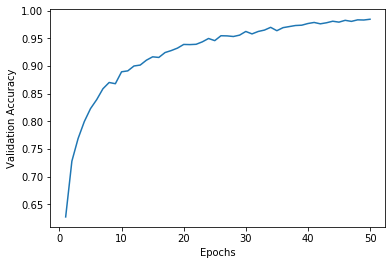

In [83]:
plt.plot(range(1, len(average_accuracy_history) + 1), average_accuracy_history)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

In [84]:
y_pred = model.predict(X_test)
print(y_pred)

[[7.00340941e-09]
 [9.99978542e-01]
 [1.00000000e+00]
 [9.98639166e-01]
 [1.38433313e-03]
 [9.91896689e-01]
 [1.00000000e+00]
 [9.99999046e-01]
 [9.99995828e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.27456129e-01]
 [9.99831319e-01]
 [2.80771226e-01]
 [4.05958053e-06]
 [3.19149112e-04]
 [1.00000000e+00]
 [7.20748517e-07]
 [9.99999642e-01]
 [3.22506299e-10]
 [6.80918038e-01]
 [1.07836428e-07]
 [1.00000000e+00]
 [9.98850584e-01]
 [9.99983668e-01]
 [1.91681147e-06]
 [4.35236667e-04]
 [9.24656760e-08]
 [1.42610706e-05]
 [1.40761118e-03]
 [9.99999881e-01]
 [9.99962568e-01]
 [9.99999881e-01]
 [9.98645008e-01]
 [6.22148156e-01]
 [9.96356010e-01]
 [1.00000000e+00]
 [9.99940991e-01]
 [9.99887705e-01]
 [9.99469936e-01]
 [3.87313690e-07]
 [5.83523870e-05]
 [9.41506570e-08]
 [9.90386248e-01]
 [9.99999523e-01]
 [3.93579919e-10]
 [9.99996305e-01]
 [1.63077936e-03]
 [9.99999762e-01]
 [9.19688432e-07]
 [9.51838076e-01]
 [9.99999881e-01]
 [1.00000000e+00]
 [9.99981880e-01]
 [9.999017

In [85]:
score = model.evaluate(X_test, y_test,verbose=1)
print(score)

173/173 [==============================] - 0s 498us/sample - loss: 0.5542 - accuracy: 0.9075
[0.5541522769914197, 0.90751445]


In [86]:
print(confusion_matrix(y_test, y_pred.round()))
print(classification_report(y_test,y_pred.round()))

[[ 50   9]
 [  7 107]]
              precision    recall  f1-score   support

           0       0.88      0.85      0.86        59
           1       0.92      0.94      0.93       114

    accuracy                           0.91       173
   macro avg       0.90      0.89      0.90       173
weighted avg       0.91      0.91      0.91       173



0.95985727029438


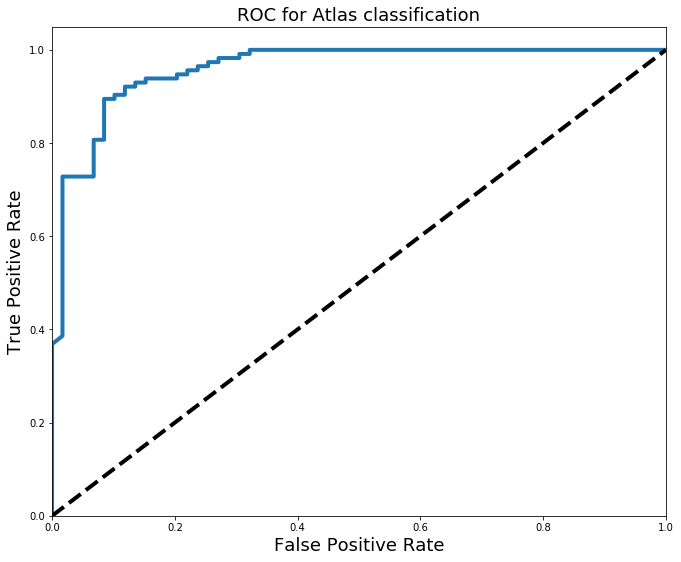

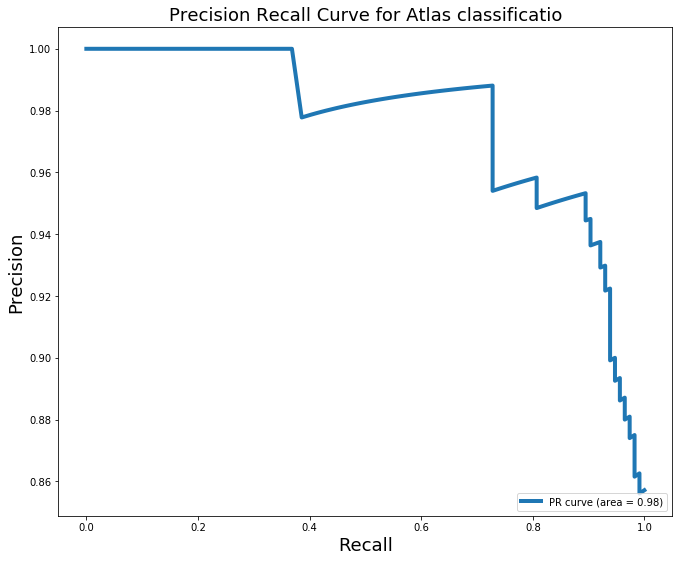

In [87]:
FPR, TPR, _ = roc_curve(y_test, y_pred)
ROC_AUC = auc(FPR, TPR)
print (ROC_AUC)

plt.figure(figsize =[11,9])
plt.plot(FPR, TPR, label= 'ROC curve(area = %0.2f)'%ROC_AUC, linewidth= 4)
plt.plot([0,1],[0,1], 'k--', linewidth = 4)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('ROC for Atlas classification', fontsize= 18)
plt.show()
#Precision recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
PR_AUC = auc(recall, precision)

plt.figure(figsize=[11,9])
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % PR_AUC, linewidth=4)
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision Recall Curve for Atlas classificatio', fontsize=18)
plt.legend(loc="lower right")
plt.show()